# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

This notebook contains the part 4 of the miniproject - the personal project. In this part we investigate the **classification between excitatory and inhibitory cells and the classification within inhibitory cell types in free whisking.**



#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [4]:
# Load the first dataset
df_1 = pd.read_csv('../data/df_1_free.csv')
df_1.head(3)

,Unnamed: 0,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,0,AP032_1,PV,0.875000,-0.040795,0.608929,-0.064378,0.005948,0.000763,0.000070
1,1,AP032_2,PV,1.857143,-0.040812,0.993269,-0.056189,0.005208,0.000635,0.000090
2,2,AP035_1,PV,2.100000,-0.037562,0.786111,-0.058273,0.006374,0.000775,0.000053


In [5]:
# Load the second dataset
df_2 = pd.read_csv('../data/df_2_free.csv')
df_2.head(3)

,Unnamed: 0,cell_id,cell_type,numb_events,wp_avg,wp_amplitude_pre,wp_amplitude_post,vm_avg,vm_amplitude_pre,vm_amplitude_post,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
0,0,AP032_1,PV,17,[-139.34721176 -139.41210588 -139.50944706 -13...,-139.536777,-135.226516,[-0.05683997 -0.05685285 -0.0568672 ... -0.05...,-55.504155,-55.399560,[0. 0. 0. ... 0. 0. 0.],[27.05882353 22.35294118 18.82352941 24.705882...,23.241104,27.065590
1,1,AP032_2,PV,4,[-139.157625 -139.319675 -139.157625 -139.1576...,-139.157622,-134.807553,[-0.0507625 -0.05074375 -0.05072891 ... -0.04...,-48.994021,-50.584425,[0. 0. 0. ... 0. 0. 0.],[35. 15. 45. 25. 25. 15. 15. 5. 15. 15. 20. ...,30.007502,8.752188
2,2,AP035_1,PV,8,[-131.4792875 -131.5651625 -131.3075125 -131.3...,-131.406960,-125.811327,[-0.05370352 -0.05371172 -0.05371602 ... -0.05...,-54.334653,-59.056842,[0. 0. 0. ... 0. 0. 0.],[27.5 20. 17.5 32.5 32.5 15. 2.5 10. 12.5 ...,24.381095,7.501875


COMPILE FROM HERE

## Between excitatory and inhibitory

In [290]:
# Merge them and suppress unwanted columns
df_test1 = df_1.merge(df_2, on=['cell_id', 'cell_type'])
df_test1 = df_test1.drop(['Unnamed: 0_x', 'Unnamed: 0_y','cell_id', 'wp_avg', 'vm_avg', 'ap_avg', 'ap_psth'], axis=1)

value1 = df_test1['cell_type']=='EXC'

df_test1['cell_type']=value1

index_col = list(df_test1['cell_type'].unique())

# Transform the labels into numbers
df_test1['cell_type'] = df_test1['cell_type'].apply(index_col.index)


In [291]:
# keep mean firing rate, sd firing rate, mean ap duration, sd ap duration, mean vm, sd vm
#df_test1 = df_test1.drop(['ap_threshold','fft_low','fft_high','std_vm',],axis=1)
df_test1.fillna(0, inplace=True)


In [292]:
# Create the X, y datasets
X = df_test1.loc[:, df_test1.columns != 'cell_type']
y = df_test1['cell_type']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Multiple Regression

Logistic Regression Accuracy: 0.9148936170212766


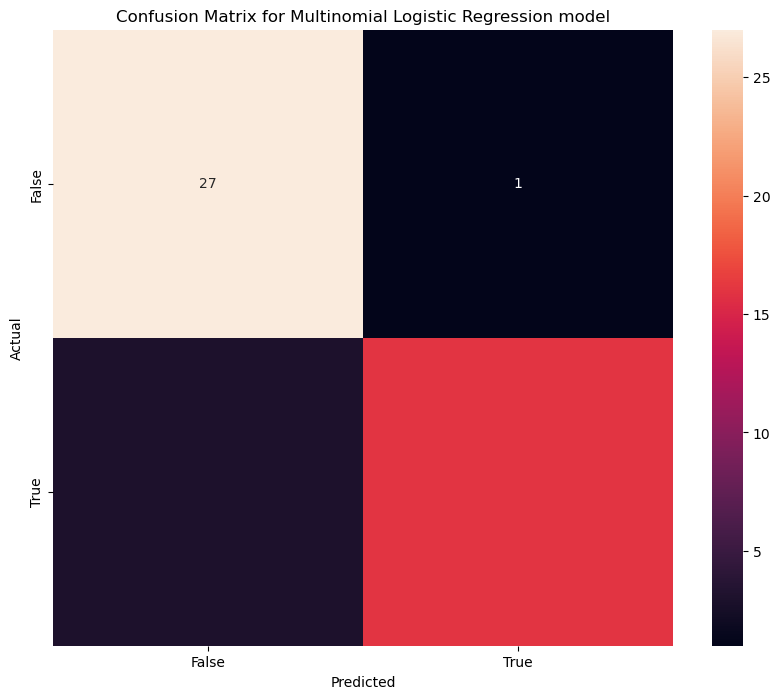

In [293]:
# Create Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

# Fit the model to the training data
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')

# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_df_lr = pd.DataFrame(cm_lr, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_lr, annot=True)
plt.title('Confusion Matrix for Multinomial Logistic Regression model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Support Vector Machine

SVM accuracy: 0.9148936170212766


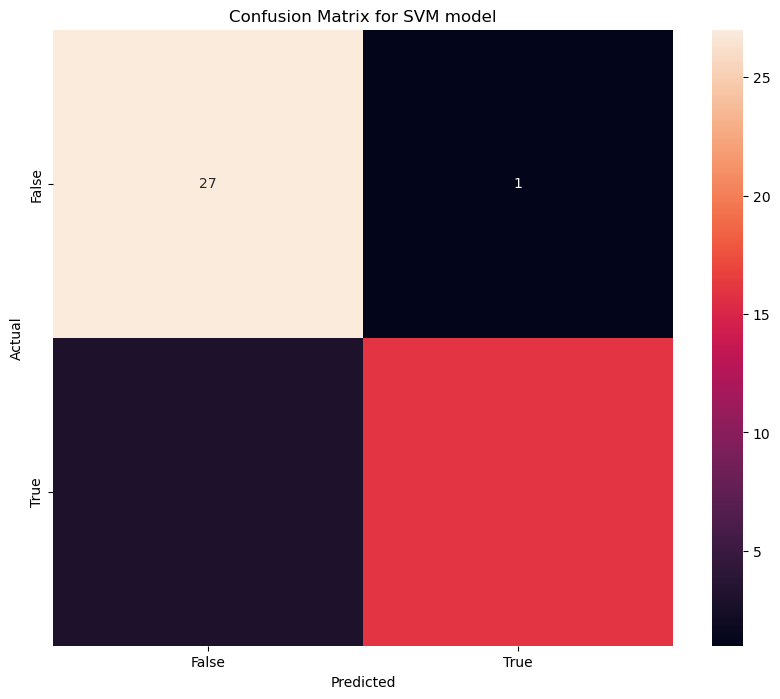

In [294]:
# Create SVM model
svm = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM accuracy: {accuracy_svm}')

# Create confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_df_svm = pd.DataFrame(cm_svm, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_svm, annot=True)
plt.title('Confusion Matrix for SVM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Between Inhibitory cells

In [296]:
# Merge them and suppress unwanted columns
df_test2 = df_1.merge(df_2, on=['cell_id', 'cell_type'])
df_test2 = df_test2.drop(['Unnamed: 0_x', 'Unnamed: 0_y','cell_id', 'wp_avg', 'vm_avg', 'ap_avg', 'ap_psth'], axis=1)

# remove excitatory cells
excitatory_cells = list(np.where(df_test2['cell_type']=='EXC')[0])
df_test2 = df_test2.drop(excitatory_cells,axis=0)
# reset indices
df_test2.reset_index(drop=True,inplace=True)


In [297]:
index_col = list(df_test2['cell_type'].unique())

# Transform the labels into numbers
df_test2['cell_type'] = df_test2['cell_type'].apply(index_col.index)
df_test2.head(1)

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,numb_events,wp_amplitude_pre,wp_amplitude_post,vm_amplitude_pre,vm_amplitude_post,ap_fr_pre,ap_fr_post
0,0,0.875,-0.040795,0.608929,-0.064378,0.005948,0.000763,0.00007,17,-139.536777,-135.226516,-55.504155,-55.39956,23.241104,27.06559


In [298]:
#df_test2.insert(loc=np.shape(df_test2)[1],column='delta_fr', value=df_test2['ap_fr_post']-df_test2['ap_fr_pre'])
#df_test2.insert(loc=np.shape(df_test2)[1],column='delta_vm', value=df_test2['vm_amplitude_post']-df_test2['vm_amplitude_pre'])
#df_test2.insert(loc=np.shape(df_test2)[1],column='deltaFR_vs_deltaAMP', value=df_test2['delta_fr']/df_test2['delta_vm'])
#df_test2['deltaFR_vs_deltaAMP'] = df_test2['deltaFR_vs_deltaAMP'].fillna(0)
#df_test2 = df_test2.drop(['delta_fr','delta_vm'],axis=1)

In [299]:
# keep mean firing rate, mean ap duration, sd vm, fft_low
#df_test2 = df_test2.drop(['fft_high'],axis=1)
df_test2.fillna(0, inplace=True)

In [300]:
# Create the X, y datasets
X = df_test2.loc[:, df_test2.columns != 'cell_type']
y = df_test2['cell_type']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Multiple Logistic Regression

Logistic Regression Accuracy: 0.7272727272727273


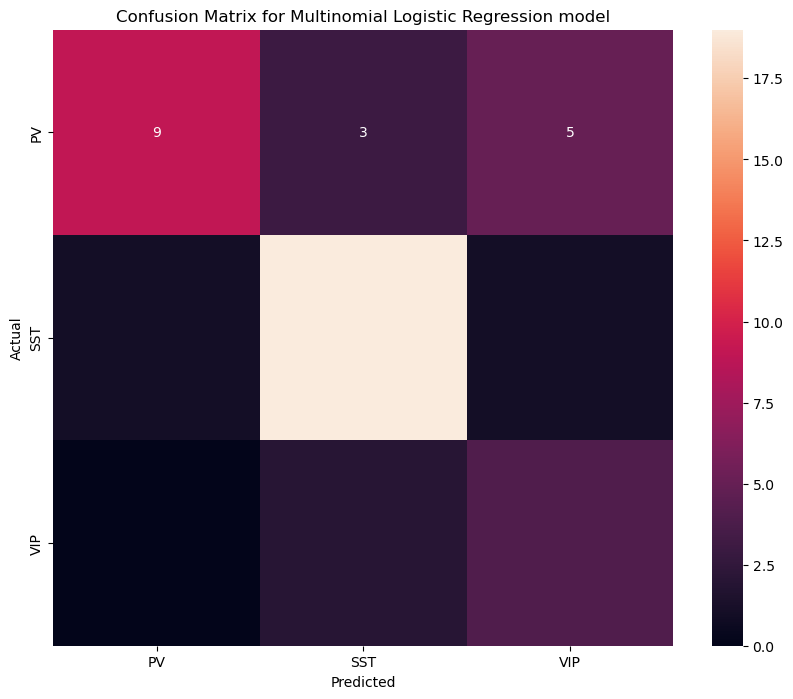

In [301]:
# Create Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

# Fit the model to the training data
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')

# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_df_lr = pd.DataFrame(cm_lr, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_lr, annot=True)
plt.title('Confusion Matrix for Multinomial Logistic Regression model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Random Forest accuracy: 0.7954545454545454


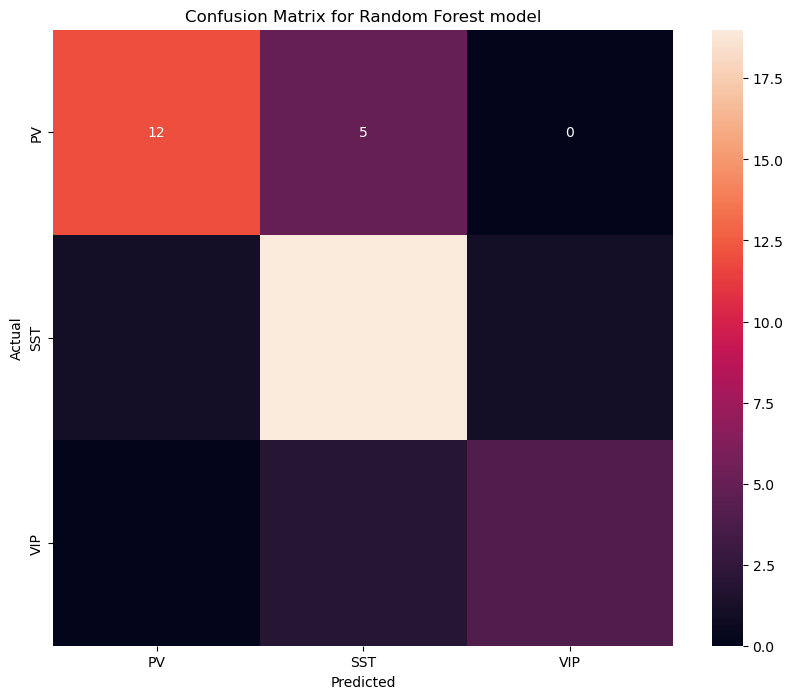

In [302]:
# Create Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)
#y_probs_rf = rf.predict_proba(X_test)
#roc_auc_rf = roc_auc_score(y_test, y_probs_rf, multi_class='ovr', average='micro')
#fpr_rf, tpr_rf, _ = roc_curve(y_test.ravel(), y_probs_rf.ravel())

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest accuracy: {accuracy_rf}')

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_rf, annot=True)
plt.title('Confusion Matrix for Random Forest model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


KNN accuracy: 0.8181818181818182


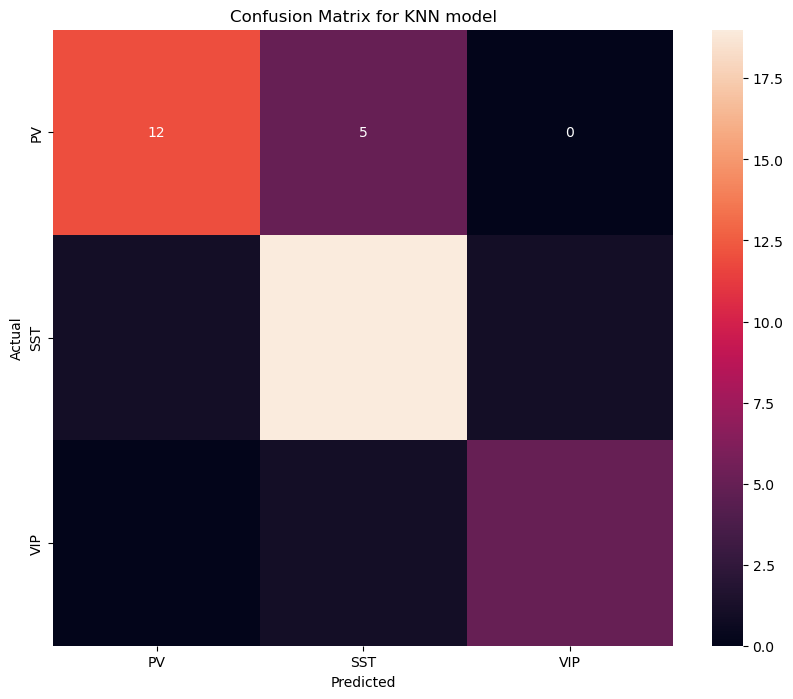

In [303]:
# Create knn model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN accuracy: {accuracy_knn}')

# Create confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_df_knn = pd.DataFrame(cm_knn, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_knn, annot=True)
plt.title('Confusion Matrix for KNN model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM accuracy: 0.7272727272727273


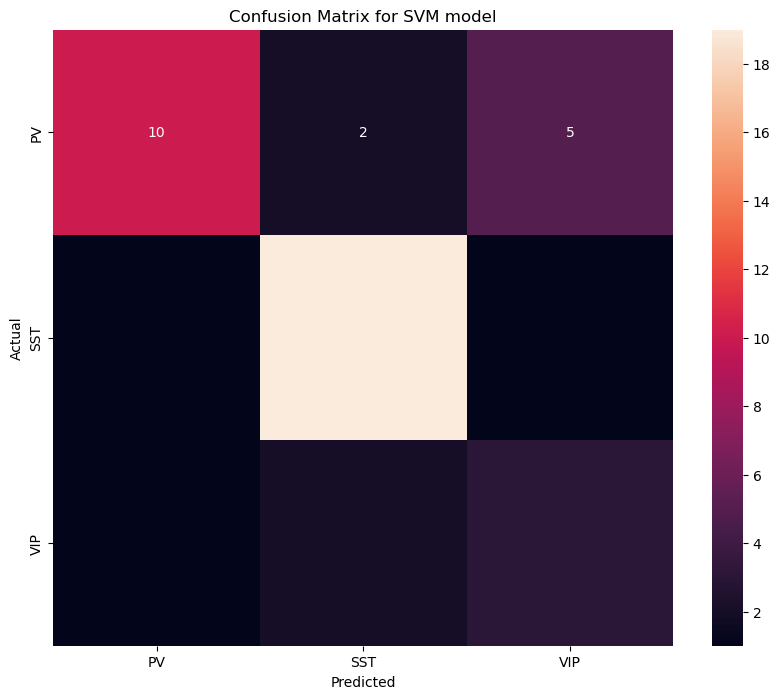

In [304]:
# Create SVM model
svm = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM accuracy: {accuracy_svm}')

# Create confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_df_svm = pd.DataFrame(cm_svm, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_svm, annot=True)
plt.title('Confusion Matrix for SVM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()